In [1]:
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.cluster import KMeans
import xgboost as xgb

train = pd.read_csv('train_updated.csv')
train = pd.DataFrame(train)


test = pd.read_csv('test_for_submissions.csv')
test = pd.DataFrame(test)


In [2]:
train2 =  train[['deviceid', 'chargecycles', 'dischargecycles', 'total_off_time',
       'number_times_restart', 'avg_volt_change_charging',
       'avg_volt_change_discharging', 'avg_time_charging',
       'avg_time_discharging', 'max_voltage_day', 'piececount', 'cycle_time',
       'charge_cycle_time_below_12', 'avg_time_charging_lag1', 'avg_time_charging_lag2',
       'avg_time_charging_lag3', 'avg_time_charging_lag4',
       'avg_time_discharging_lag1', 'avg_time_discharging_lag2',
       'avg_time_discharging_lag3', 'avg_time_discharging_lag4',
       'charging_rate_lag3', 'discharging_rate_lag3', 'charging_rate_lag4',
       'discharging_rate_lag4','fail_7']].copy()

test2 = test[['deviceid', 'chargecycles', 'dischargecycles', 'total_off_time',
       'number_times_restart', 'avg_volt_change_charging',
       'avg_volt_change_discharging', 'avg_time_charging',
       'avg_time_discharging', 'max_voltage_day', 'piececount', 'cycle_time',
       'charge_cycle_time_below_12', 'avg_time_charging_lag1', 'avg_time_charging_lag2',
       'avg_time_charging_lag3', 'avg_time_charging_lag4',
       'avg_time_discharging_lag1', 'avg_time_discharging_lag2',
       'avg_time_discharging_lag3', 'avg_time_discharging_lag4',
       'charging_rate_lag3', 'discharging_rate_lag3', 'charging_rate_lag4',
       'discharging_rate_lag4']].copy()

train2 = train2.set_index('deviceid') 
test2 = test2.set_index('deviceid')

In [3]:
y = train2["fail_7"]  # Specify one column as the target variable
X = train2.drop('fail_7', axis = 1)  # Specify at least two columns as features


# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=51
)


In [4]:
rs_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": list((range(4, 12))),
    "min_samples_split": list((range(2, 5))),
    "min_samples_leaf": list((range(1, 5))),
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
}

# Create a decision tree classifer object
clf = DecisionTreeClassifier(random_state=51)

# Instantiate RandomizedSearchCV() with clf and the parameter grid
clf_rs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=20,  # Number of parameter candidate settings to sample
    verbose=3,  # The higher this is, the more messages are outputed
    random_state=61,
)

# Train the model on the training set
clf_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
#print("Best parameters found: ", clf_rs.best_params_)
#print("Best accuracy found: ", clf_rs.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END ccp_alpha=0, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=2;, score=0.801 total time=   0.3s
[CV 2/3] END ccp_alpha=0, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=2;, score=0.806 total time=   0.3s
[CV 3/3] END ccp_alpha=0, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=2;, score=0.811 total time=   0.3s
[CV 1/3] END ccp_alpha=0, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=3;, score=0.803 total time=   0.2s
[CV 2/3] END ccp_alpha=0, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=3;, score=0.809 total time=   0.2s
[CV 3/3] END ccp_alpha=0, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=3;, score=0.813 total time=   0.2s
[CV 1/3] END ccp_alpha=0, criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=3;, score=0.801 total time=   0.1s
[CV 2/3] END ccp_alpha=0,

In [5]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "criterion": "gini",  # Function to measure the quality of a split: 'Gini' or 'Entropy'
    "max_depth": 5,  # Max depth of the tree
    "min_samples_split": 2,  # Min number of samples required to split a node
    "min_samples_leaf": 3,  # Min number of samples required at a leaf node
    "ccp_alpha": 0.001,  # Cost complexity parameter for pruning
    "random_state": 42,
}

# Create a DecisionTreeClassifier object with the parameters above
clf = DecisionTreeClassifier(**params)

# Train the decision tree classifer on the train set
clf = clf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = clf.predict(X_test)

In [6]:
test_pred = clf.predict(test2)

In [7]:
test_pred

array([1, 0, 0, ..., 0, 1, 0])

In [8]:
test2['fail_7'] = test_pred

In [14]:
final = test2.iloc[ : , 24:]

In [15]:
final

,fail_7
deviceid,
42979,1
14911,0
48386,0
18822,0
49810,0
...,...
23329,0
35263,0
12544,0


In [10]:
test2.fail_7.value_counts(normalize = True)

0    0.868
1    0.132
Name: fail_7, dtype: float64

In [16]:
#final.to_csv('forecasts_submission.csv')

[Text(0.5, 0.9166666666666666, 'charge_cycle_time_below_12 <= 0.5\ngini = 0.357\nsamples = 28350\nvalue = [21767, 6583]\nclass = 0'),
 Text(0.4090909090909091, 0.75, 'gini = 0.159\nsamples = 11588\nvalue = [10582, 1006]\nclass = 0'),
 Text(0.5909090909090909, 0.75, 'discharging_rate_lag3 <= 0.152\ngini = 0.444\nsamples = 16762\nvalue = [11185, 5577]\nclass = 0'),
 Text(0.36363636363636365, 0.5833333333333334, 'discharging_rate_lag3 <= -0.128\ngini = 0.413\nsamples = 14642\nvalue = [10376, 4266]\nclass = 0'),
 Text(0.18181818181818182, 0.4166666666666667, 'charging_rate_lag3 <= -0.205\ngini = 0.497\nsamples = 2491\nvalue = [1148, 1343]\nclass = 1'),
 Text(0.09090909090909091, 0.25, 'gini = 0.246\nsamples = 348\nvalue = [298, 50]\nclass = 0'),
 Text(0.2727272727272727, 0.25, 'charging_rate_lag3 <= 0.045\ngini = 0.479\nsamples = 2143\nvalue = [850, 1293]\nclass = 1'),
 Text(0.18181818181818182, 0.08333333333333333, 'gini = 0.442\nsamples = 1857\nvalue = [613, 1244]\nclass = 1'),
 Text(0.3

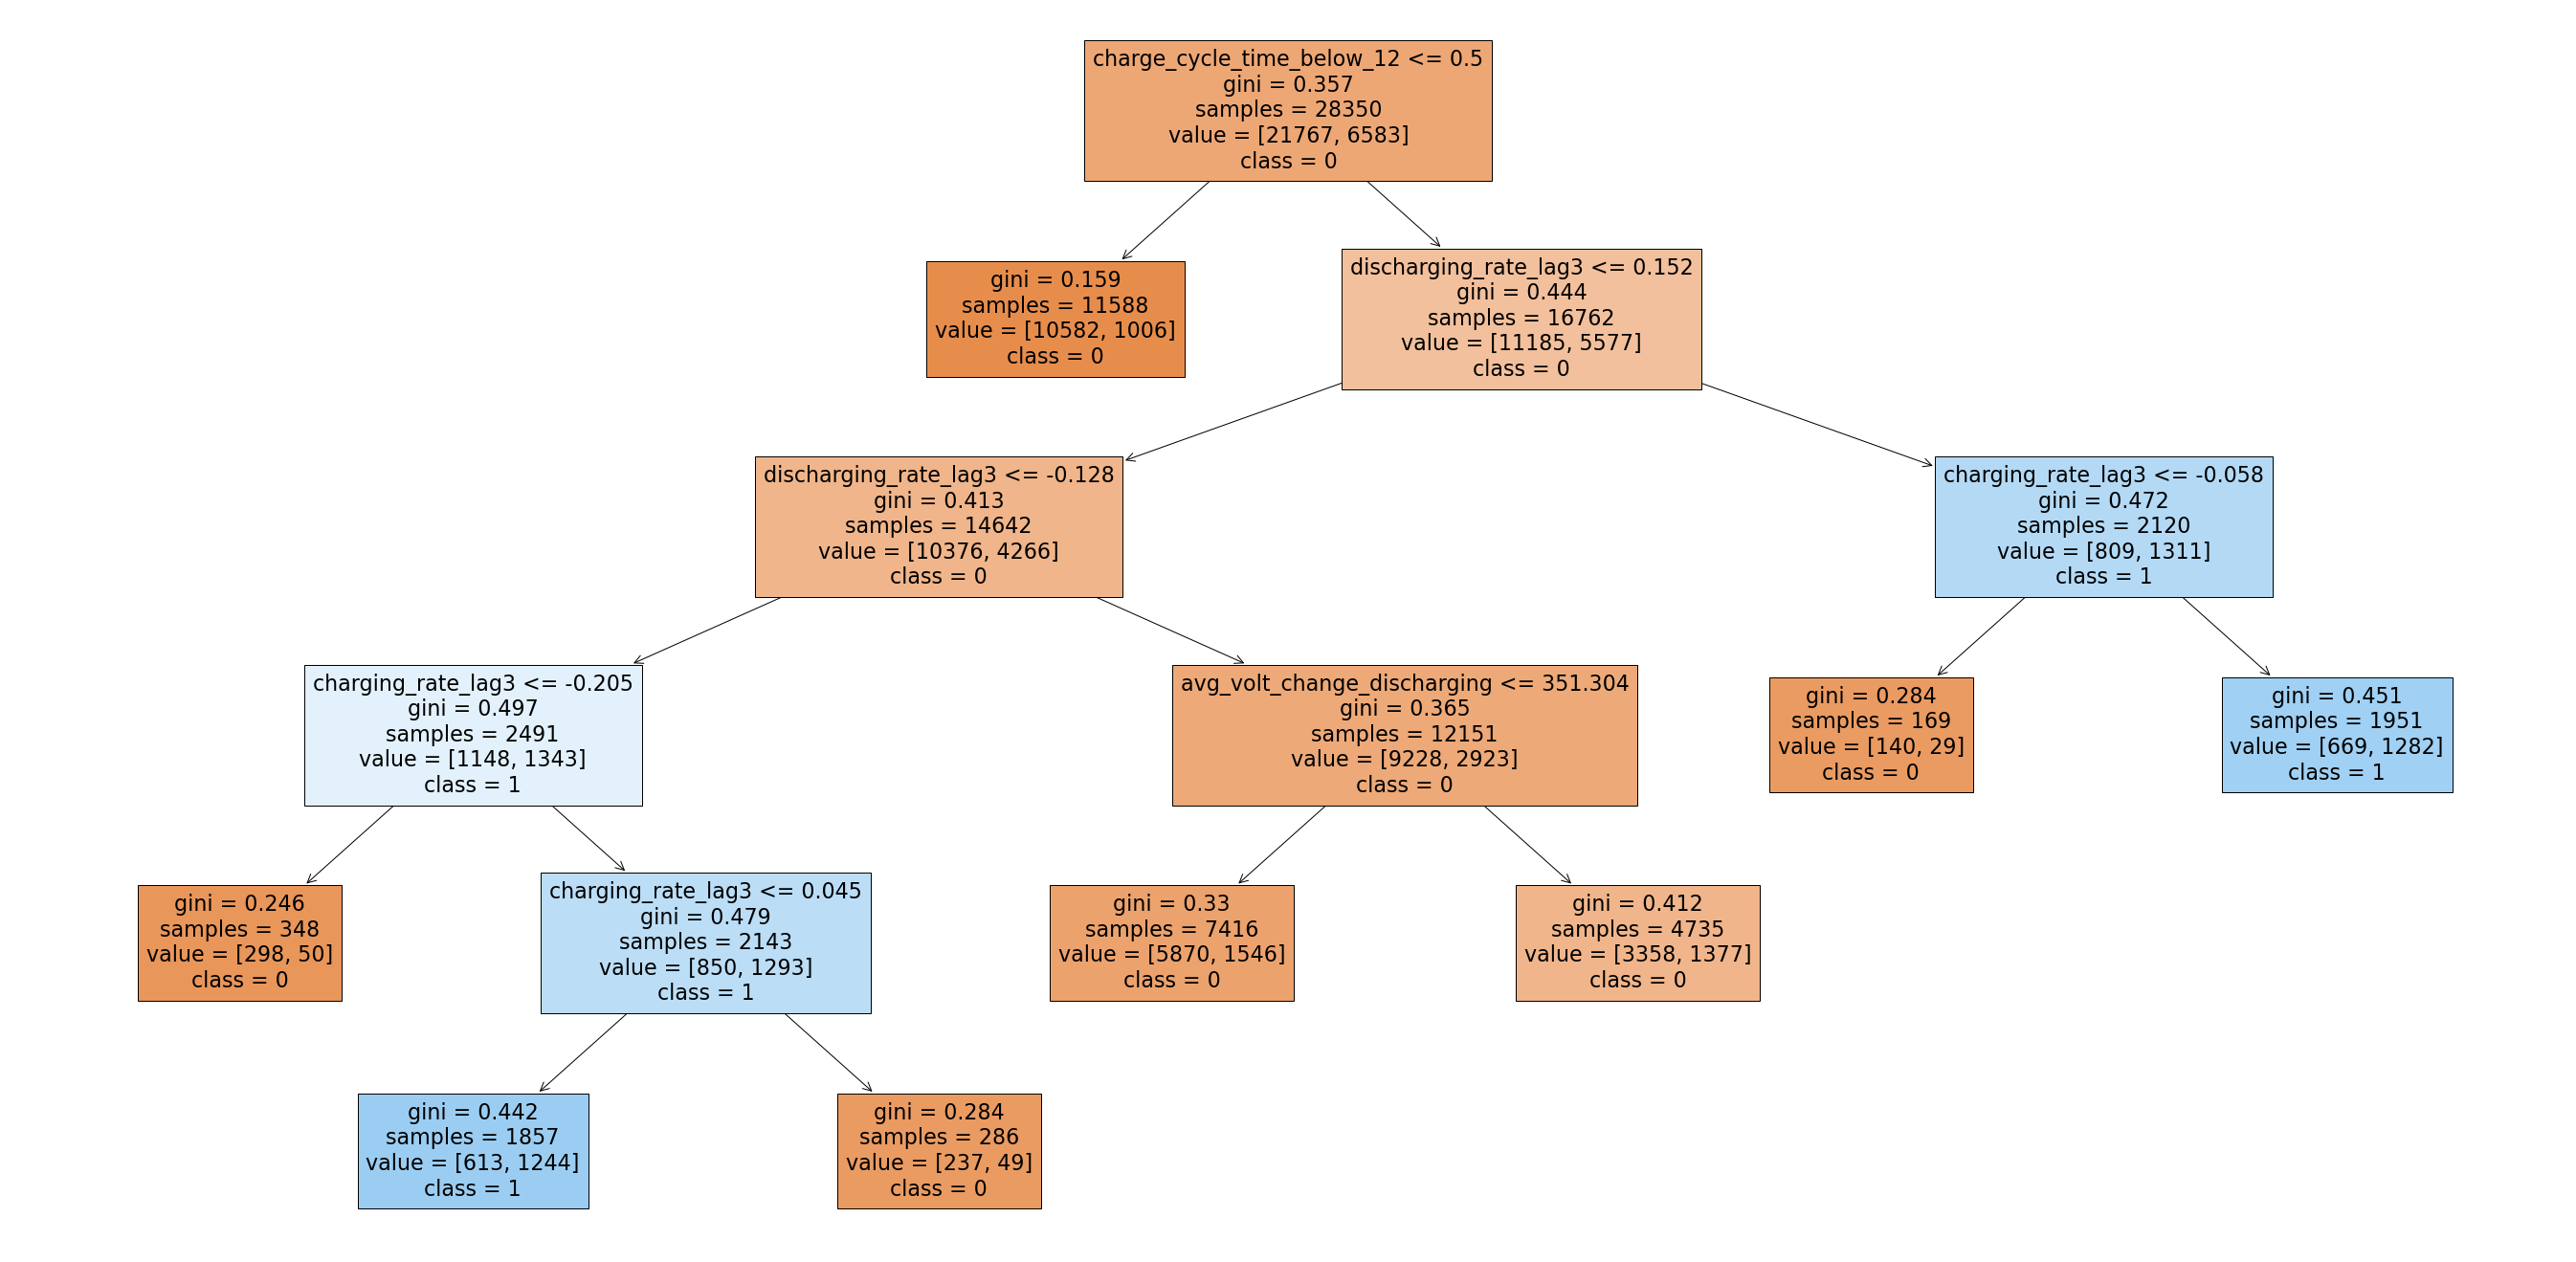

In [12]:
plt.figure(figsize=(48, 24))
tree.plot_tree(clf, feature_names=X.columns, filled = True, class_names = ['0','1'])